# Import package 

In [1]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.octave import *
from qm.qua import *
from qm import generate_qua_script

#General os library 
import os
import time
import sys


import matplotlib.pyplot as plt
from qualang_tools.units import unit
from set_octave import get_L0_and_IF
from configuration_steady_state import *
from qm import SimulationConfig, LoopbackInterface
from qualang_tools.units import unit
from qualang_tools.loops import from_array
u = unit()
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.addons.variables import assign_variables_to_element

#Path for HQCPC7 
sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Analysis_Function\NonLinearRes')
sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Drivers\Drivers') #path for the analysis function

#Path for HQC PC15 
# sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Analysis_Function\NonLinearRes')
# sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Drivers')
import AnFunc as an # analysis function
#import AnFunc as an 
import scipy.io
from scipy import signal 
from scipy.optimize import curve_fit

In [2]:
def update_readout_lenght(Readout_Len,config,qmm):
    """ Macro to update the readout length in the configuration file"""
    
    config["pulses"]["zero_pulse"]["length"]=Readout_Len
    config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_pulse_amplitude(pulse_amp,config,qmm):
    config["waveforms"]["twoPhoton_wf"]['sample']=pulse_amp
    
    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_two_photon_lenght(twoPhoton_len,config,qmm):
    """ Update the length of the fluxline pulse in the configuration file"""
    config["pulses"]["twoPhoton"]["length"]=twoPhoton_len


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_time_of_flight(time_of_flight,config,qmm):
    """ Update the time_of_flight of the qm in the configuration file """
    config["elements"]["resonator"]["time_of_flight"]=time_of_flight
    
    qm=qmm.open_qm(config)
    
    return config, qm

def voltage_convertion(attenuation,v_in):
    v_out=10**(attenuation/20)*v_in
    
    return v_out


# OPX configuration

In [3]:
#Octave & OPX configuration 
Saving_Path=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\131\\"
Cooldown_Date="2023_05_05"


opx_ip = '128.178.175.167'
opx_port = 81
octave_ip = '128.178.175.167'
octave_port = 53


octave_config = QmOctaveConfig()
octave_config.set_calibration_db(os.getcwd()) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave


qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)


#Mixers for the fluxline 
octave_output_gain=-10

qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 
qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", octave_output_gain)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)  #RFOutputMode.trig_normal

#Mixers for the resonator 
qm.octave.set_qua_element_octave_rf_in_port("resonator", "octave1", 1) #input port 1 is set for the resonator 
qm.octave.set_downconversion("resonator", lo_source=RFInputLOSource.Internal)  # The LO for the demodulation is the interal LO  
qm.octave.set_lo_frequency("resonator", LO_readout)  # assign the LO inside the octave to element

2023-05-10 09:38:10,777 - qm - INFO - Performing health check
2023-05-10 09:38:10,791 - qm - WARNING -   HC Warning: Potential hardware issue with QSync in controller con1, multiple controllers sync cannot be guaranteed, please inform QM
2023-05-10 09:38:10,792 - qm - INFO - Health check passed


In [4]:
#Setting the gain
gain=0
config['controllers']['con1']['analog_inputs'][1]["gain_db"]=gain
config['controllers']['con1']['analog_inputs'][2]["gain_db"]=gain
qm = qmm.open_qm(config)

time_of_flight=24

config, qm=update_time_of_flight(time_of_flight,config,qmm)

pulse_amp=0.125
config,qm=update_pulse_amplitude(pulse_amp,config,qmm)


# Display parameters

In [5]:
print("LO of resonator : {} GHz".format(config['elements']['resonator']["mixInputs"]["lo_frequency"]/1e9))
print("IF of resonator : {} GHz".format(config['elements']['resonator']['intermediate_frequency']/1e9))
print("Time of flight of resonator : {} ns".format(config['elements']['resonator']['time_of_flight']))
print("Readout time resonator : {} ns".format(config["pulses"]["zero_pulse"]["length"]))
print("LO of fluxline: {} GHz".format(config['elements']['fluxline']["mixInputs"]["lo_frequency"]/1e9))
print("IF of fluxline : {} GHz".format(config['elements']['fluxline']['intermediate_frequency']/1e9))
print("Fluxline pulse time : {} ns".format(config["pulses"]["twoPhoton"]["length"]))
print("Fluxline amplitude : {} V".format(config["waveforms"]["twoPhoton_wf"]['sample']))

LO of resonator : 4.3 GHz
IF of resonator : 0.318 GHz
Time of flight of resonator : 24 ns
Readout time resonator : 2000 ns
LO of fluxline: 8.6 GHz
IF of fluxline : 0.0995 GHz
Fluxline pulse time : 1000 ns
Fluxline amplitude : 0.125 V


# Testing the pump 

In [6]:
#Mixer Calibration 
#Calibration of the fluxline mixer for the pump 
qm.octave.calibrate_element("fluxline", [get_L0_and_IF(config, "fluxline")])  
qm = qmm.open_qm(config)

qm.octave.calibrate_element("resonator", [get_L0_and_IF(config, "resonator")])  
qm = qmm.open_qm(config)

2023-05-10 09:38:21,450 - qm - INFO - Flags: 
2023-05-10 09:38:21,450 - qm - INFO - Compiling program
2023-05-10 09:38:23,817 - qm - INFO - Sending pre-compiled program to QOP
2023-05-10 09:38:27,474 - qm - INFO - Flags: 
2023-05-10 09:38:27,475 - qm - INFO - Compiling program
2023-05-10 09:38:29,804 - qm - INFO - Sending pre-compiled program to QOP


In [ ]:
# Testing the pump 
with program() as TwoPhoton:
    with infinite_loop_():
        play("pumping"*amp(0.1), 'fluxline')
        
job = qm.execute(TwoPhoton)

In [32]:
#Two stop the two photon pumping 
job.halt()

True

# Steady state 

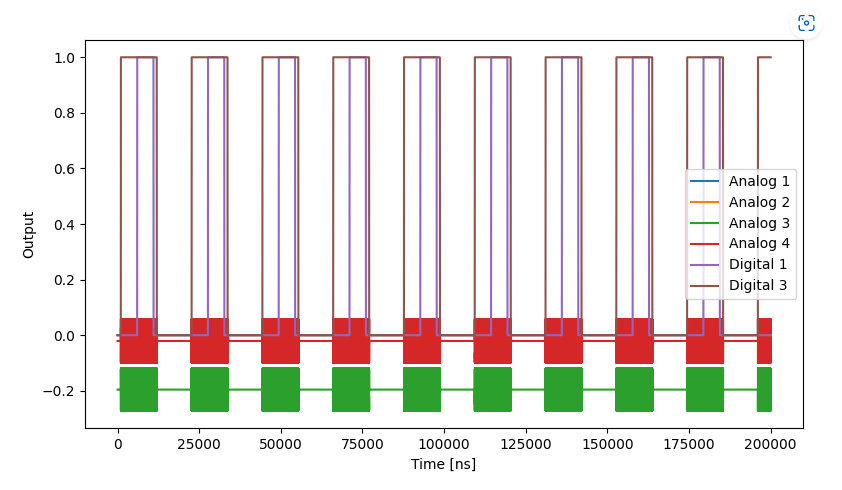

Here, to get the steady state, we apply the pump at a given frequency and wait (pulse_delay_ss) time before making the readout with the readout len. Therefore, the resonator waiting must be larger than the Readout lengt. Since the pulse is looped, multiple times, we can keep it to a length of 1_000. After the readout has been down, the pulse is stopped for a time cooling_down.

## Steady state single 

In [26]:

Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

#Two photon length should not be changed 
twoPhoton_len=1_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)



amp_factor=0.3


n_repetition=1000

IF_pump=140e6 #where we go  
IF_left=138e6  # whre we start
pump_step=0.01e6


number_frequency=int(np.ceil((IF_pump-IF_left)/pump_step))

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

pulse_delay_ss= 1_000_000 # to to play the pulse before making a last probe 

resonator_waiting=(pulse_delay_ss-Readout_Len)//4

cooling_down= 1_000_000 //4 #time between succesinve frequencies 


time_per_iteration=((pulse_delay_ss+cooling_down*4)*number_frequency)*1e-9
Total_time=time_per_iteration*n_repetition/60
print("Time per iteration : {} s".format(time_per_iteration))
print("Total time : {} min".format(Total_time))

Time per iteration : 0.4 s
Total time : 6.666666666666667 min


In [27]:
%matplotlib qt

with program() as hello_qua:
    
    f = declare(int)
    f_readout= declare(int)
    
    n_rep = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    i = declare(int)
    
    I_st = declare_stream()
    Q_st = declare_stream()
    n_rep_st=declare_stream()
    f_st = declare_stream() #frequency at which I am measuring 
    
    assign_variables_to_element("resonator", I,Q) 
    

    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1): 
        

        with for_(f, IF_left, f<IF_pump, f+pump_step):

            assign(f_readout,LO_diff+f/2) # update the readout frequency 
            update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 

            update_frequency('fluxline', f, keep_phase=True)


            with for_(i, 0, i <pulse_delay_ss/twoPhoton_len+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle
                play("pumping" * amp(amp_factor), 'fluxline')  # Play the pulse on the fluxline

            wait(resonator_waiting,"resonator")    

            measure(
            "fake_readout",
            "resonator",
            None,
            dual_demod.full("cos", "out1", "sin", "out2", I),
            dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            wait(cooling_down)



            assign(I,Math.abs(I))
            assign(Q,Math.abs(Q))

            save(I, I_st)
            save(Q, Q_st)  
            save(f, f_st)


        save(n_rep, n_rep_st)   

    with stream_processing():
        I_st.buffer(number_frequency).average().save("I")
        Q_st.buffer(number_frequency).average().save("Q")
        f_st.buffer(number_frequency).save("f")
        n_rep_st.save("n_rep")
    
    

simulation = False  

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, hello_qua, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={"1","3"})
    
    # Get the frequency map 
    sample=job.get_simulated_samples()
    x=sample.con1.analog["4"] # get analog 4
    NFFT = 2**10
    Fs = 1e9
    fig = plt.figure()
    ax1 = plt.subplot(111)
    Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=100, cmap=plt.cm.gist_heat)
    plt.show()
    ax1.set_xticklabels((ax1.get_xticks() * 1e6).astype(int))
    #ax1.set_yticklabels((ax1.get_yticks() / 1e6).astype(int))
    plt.xlabel("t [us]")
    plt.ylabel("f [MHz]")

    
else:
    job = qm.execute(hello_qua)
    results = fetching_tool(job, data_list=["I","Q","f","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        
        I,Q,f, n_rep = results.fetch_all()

        Id = u.demod2volts(I, Readout_Len) ## that is why i want to demodulate .... diviser par la duree du pulse Readout_lEN 
        Qd = u.demod2volts(Q, Readout_Len)
        
        plt.subplot(111)
        fig.suptitle(str(n_rep))
        plt.cla()
        plt.plot(f,np.sqrt(I**2+Q**2),".", markersize=2)
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)

2023-04-26 20:56:55,281 - qm - INFO - Flags: 
2023-04-26 20:56:55,282 - qm - INFO - Sending program to QOP
2023-04-26 20:56:55,936 - qm - INFO - Executing program
Execution stopped by user!


## Steady state map

In [7]:
%matplotlib qt
Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

twoPhoton_len=1_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)


# Test sticky

a_min=0.25
a_max=2
da=0.05
amp_factor=np.arange(a_min,a_max,da)

#amp_factor=np.array([0.2,0.25,0.3,0.35,0.4])

n_repetition=1000

IF_pump=99.9e6  #where we go  
IF_left=98.9e6   # whre we start
pump_step=0.02e6


number_frequency=int(np.ceil((IF_pump-IF_left)/pump_step))

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

pulse_delay_ss= 1_000_000 # to to play the pulse before making a last probe 

resonator_waiting=(pulse_delay_ss-Readout_Len)//4

cooling_down= 1_000_000 //4 #time between succesinve frequencies 


time_per_iteration=((pulse_delay_ss+cooling_down*4)*number_frequency)*1e-9
Total_time=time_per_iteration*n_repetition*len(amp_factor)/60
print("Time per iteration : {} s".format(time_per_iteration))
print("Total time : {} min".format(Total_time))

Time per iteration : 0.1 s
Total time : 58.333333333333336 min


In [8]:
%%time

with program() as hello_qua:
    
    f = declare(int)
    f_readout= declare(int)
    
    n_rep = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    i = declare(int)
    a = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    n_rep_st=declare_stream()
    f_st = declare_stream() #frequency at which I am measuring 
    
    assign_variables_to_element("resonator", I,Q) 
    

    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1): 
        
        #loop over amplitude 
        with for_(*from_array(a, amp_factor)):
        
            with for_(f, IF_left, f<IF_pump, f+pump_step):

                assign(f_readout,LO_diff+f/2) # update the readout frequency 
                update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 

                update_frequency('fluxline', f, keep_phase=True)


                with for_(i, 0, i <pulse_delay_ss/twoPhoton_len+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle
                    play("pumping" * amp(a), 'fluxline')  # Play the pulse on the fluxline

                wait(resonator_waiting,"resonator")    

                measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )

                wait(cooling_down)



                assign(I,Math.abs(I))
                assign(Q,Math.abs(Q))

                save(I, I_st)
                save(Q, Q_st)  
                save(f, f_st)


            save(n_rep, n_rep_st)   

    with stream_processing():
        I_st.buffer(number_frequency).buffer(len(amp_factor)).average().save("I")
        Q_st.buffer(number_frequency).buffer(len(amp_factor)).average().save("Q")
        f_st.buffer(number_frequency).save("f")
        n_rep_st.save("n_rep")
    
    

simulation = False  

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, hello_qua, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={"1","3"})
    
    # Get the frequency map 
    sample=job.get_simulated_samples()
    x=sample.con1.analog["4"] # get analog 4
    NFFT = 2**10
    Fs = 1e9
    fig = plt.figure()
    ax1 = plt.subplot(111)
    Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=100, cmap=plt.cm.gist_heat)
    plt.show()
    ax1.set_xticklabels((ax1.get_xticks() * 1e6).astype(int))
    #ax1.set_yticklabels((ax1.get_yticks() / 1e6).astype(int))
    plt.xlabel("t [us]")
    plt.ylabel("f [MHz]")

    
else:
    job = qm.execute(hello_qua)
    results = fetching_tool(job, data_list=["I","Q","f","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        
        I,Q,f, n_rep = results.fetch_all()

        I = u.demod2volts(I, Readout_Len) ## that is why i want to demodulate .... diviser par la duree du pulse Readout_lEN 
        Q = u.demod2volts(Q, Readout_Len)
        
        norm=np.sqrt(I**2+Q**2)
        
        plt.subplot(111)
        fig.suptitle(str(n_rep))
        plt.cla()
        plt.pcolor(f / u.MHz, amp_factor, np.sqrt(I**2+Q**2)*1e3)
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)

2023-05-10 09:38:40,673 - qm - INFO - Flags: 
2023-05-10 09:38:40,674 - qm - INFO - Sending program to QOP
2023-05-10 09:38:41,664 - qm - INFO - Executing program
Execution stopped by user!
Wall time: 17min 33s


In [9]:
%matplotlib qt
plt.clf()
fig, ax = plt.subplots(1, 1)

ax.set_title("Steady state")
c=ax.pcolor(f / u.MHz, amp_factor, np.sqrt(I**2+Q**2)**2*1e3) # What is shown is normalized by dividing by the amplitude 
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Amplitude factor")
fig.colorbar(c,ax=ax, label="Amplitude [mv]")

### Saving 

In [10]:
#Saving the data
cooldown_date=Cooldown_Date #top folder 
device="Spectrum_QM" #second folder 
name="Map_steady_state" # third folder 
meastype="10_05_2023_quickmap" #Final file name 

datadict={}
#Configuration file copy 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["LO_readout"]=LO_readout
datadict["octave_gain"]=octave_output_gain

#Saving of parameters 
datadict["n_repetition"]=n_rep
datadict["amp_factor"]=amp_factor
datadict["Readout_Len"]=Readout_Len
datadict["IF_pump"]=IF_pump
datadict["IF_left"]=IF_left
datadict["pump_step"]=pump_step
datadict["cooling_down"]=cooling_down
datadict["pulse_delay_ss"]=pulse_delay_ss

#Saving of data 
datadict["freqs"]=f
datadict["I"]=I
datadict["Q"]=Q
datadict["config"]=config

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

saving in new directory


In [ ]:
#loading 
filepath=r"Z:\Users\beaulieu\Data\Run01\104\2023_04_14\Spectrum_QM\Map_upsweep\upsweep_pip6.npz"

npzfile=np.load(filepath,allow_pickle=True)
npzfile["multidata"][()]
f=npzfile["multidata"][()]["freqs"]
I=npzfile["multidata"][()]["I"]
Q=npzfile["multidata"][()]["Q"]
amp_factor=npzfile["multidata"][()]["amp_factor"]

## Amplitude cut 

In [88]:
%matplotlib qt
Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

twoPhoton_len=1_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)


# Test sticky



amp_factor=np.array([0.85,0.95,1.05,1.15,1.35,1.55,1.75,1.95])

n_repetition=1300

IF_pump=99.9e6  #where we go  
IF_left=98.9e6   # whre we start
pump_step=0.02e6


number_frequency=int(np.ceil((IF_pump-IF_left)/pump_step))

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

pulse_delay_ss= 30_000_000 # to to play the pulse before making a last probe 

resonator_waiting=(pulse_delay_ss-Readout_Len)//4

cooling_down= 30_000_000 //4 #time between succesinve frequencies 


#For plotting 
Gi=0.4
center_freq=   4.349764e9*2  
offset=0.0001661

time_per_iteration=((pulse_delay_ss+cooling_down*4)*number_frequency)*1e-9
Total_time=time_per_iteration*n_repetition*len(amp_factor)/60
print("Time per iteration : {} s".format(time_per_iteration))
print("Total time : {} min".format(Total_time))
amp_factor_list=amp_factor.tolist() #convert as a list to use for_each in qm 

2023-05-10 09:22:55,977 - qm - WARNING - Open QM ended with warning 0: Opening a new Quantum Machine and closing Quantum Machines: 
2023-05-10 09:22:55,978 - qm - WARNING - Open QM ended with warning 0: Quantum Machine qm-1683703332307 is canceling running job 1683548059304.
Time per iteration : 3.0 s
Total time : 520.0 min


In [83]:
%%time

with program() as hello_qua:
    
    f = declare(int)
    f_readout= declare(int)
    
    n_rep = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    i = declare(int)
    a = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    n_rep_st=declare_stream()
    f_st = declare_stream() #frequency at which I am measuring 
    
    assign_variables_to_element("resonator", I,Q) 
    

    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1): 
        
        #loop over amplitude 
        with for_each_(a, amp_factor_list):
        
            with for_(f, IF_left, f<IF_pump, f+pump_step):

                assign(f_readout,LO_diff+f/2) # update the readout frequency 
                update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 

                update_frequency('fluxline', f, keep_phase=True)


                with for_(i, 0, i <pulse_delay_ss/twoPhoton_len+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle
                    play("pumping" * amp(a), 'fluxline')  # Play the pulse on the fluxline

                wait(resonator_waiting,"resonator")    

                measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )

                wait(cooling_down)



                assign(I,Math.abs(I))
                assign(Q,Math.abs(Q))

                save(I, I_st)
                save(Q, Q_st)  
                save(f, f_st)


            save(n_rep, n_rep_st)   

    with stream_processing():
        I_st.buffer(number_frequency).buffer(len(amp_factor)).average().save("I")
        Q_st.buffer(number_frequency).buffer(len(amp_factor)).average().save("Q")
        f_st.buffer(number_frequency).save("f")
        n_rep_st.save("n_rep")
    
    

simulation = False  

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, hello_qua, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={"1","3"})
    
    # Get the frequency map 
    sample=job.get_simulated_samples()
    x=sample.con1.analog["4"] # get analog 4
    NFFT = 2**10
    Fs = 1e9
    fig = plt.figure()
    ax1 = plt.subplot(111)
    Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=100, cmap=plt.cm.gist_heat)
    plt.show()
    ax1.set_xticklabels((ax1.get_xticks() * 1e6).astype(int))
    #ax1.set_yticklabels((ax1.get_yticks() / 1e6).astype(int))
    plt.xlabel("t [us]")
    plt.ylabel("f [MHz]")

    
else:
    job = qm.execute(hello_qua)
    results = fetching_tool(job, data_list=["I","Q","f","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        
        I,Q,f, n_rep = results.fetch_all()

        I = u.demod2volts(I, Readout_Len) ## that is why i want to demodulate .... diviser par la duree du pulse Readout_lEN 
        Q = u.demod2volts(Q, Readout_Len)
        
        norm=np.sqrt(I**2+Q**2)
        
        plt.subplot(211)
        plt.cla()
        for i in range(norm.shape[0]):
            plt.plot(f,norm[i,:]**2,'.-',label=f'amp={amp_factor[i]:1f}', alpha=.9, lw=.5, ms=8)

        plt.xlabel("Pump freq")
        plt.ylabel("Amplitudes")
        plt.legend()
        fig.suptitle(str(n_rep))
            
            
        plt.subplot(212)
        plt.cla()    
        for i in range(norm.shape[0]):
            Gx=amp_factor[i]
            Pump_freq=f+LO_fluxline
            plt.plot((Pump_freq-center_freq)*Gi/Gx,(norm[i,:]-offset)**2*Gi/Gx, '.-',  label=f'Pump={amp_factor[i]:.1f}', alpha=.9, lw=.5, ms=8)
            
        plt.xlabel('$\Delta\cdot$F')
        plt.ylabel('$n\cdot F$')
        plt.legend()

            
        plt.pause(0.1)

2023-05-10 00:16:16,276 - qm - INFO - Flags: 
2023-05-10 00:16:16,276 - qm - INFO - Sending program to QOP
2023-05-10 00:16:17,354 - qm - INFO - Executing program
Wall time: 8h 40min 2s


### Plot amplitude cut 

In [11]:
f

array([98900000, 98920000, 98940000, 98960000, 98980000, 99000000,
       99020000, 99040000, 99060000, 99080000, 99100000, 99120000,
       99140000, 99160000, 99180000, 99200000, 99220000, 99240000,
       99260000, 99280000, 99300000, 99320000, 99340000, 99360000,
       99380000, 99400000, 99420000, 99440000, 99460000, 99480000,
       99500000, 99520000, 99540000, 99560000, 99580000, 99600000,
       99620000, 99640000, 99660000, 99680000, 99700000, 99720000,
       99740000, 99760000, 99780000, 99800000, 99820000, 99840000,
       99860000, 99880000], dtype=int64)

In [40]:

amp_factor=(amp_factor*0.25*10**(-10/20))**2

In [46]:
(amp_factor*0.25*10**(-10/20))**2

array([0.00076563, 0.00126563, 0.00189063, 0.00264063, 0.00351562,
       0.00451562, 0.00564063, 0.00689063])

0.85
0.95
1.05
1.15
1.35
1.55
1.75
1.95


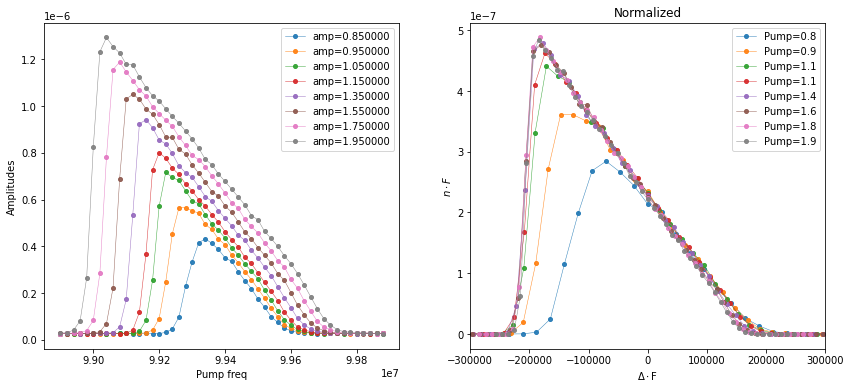

In [96]:
%matplotlib inline

fig, axs = plt.subplots( ncols=2, figsize=(14,6))
ax=axs[0]


for i in range(norm.shape[0]):
    ax.plot(f,(norm[i,:])**2,'.-',label=f'amp={amp_factor[i]:1f}', alpha=.9, lw=.5, ms=8)
  
ax.set_xlabel("Pump freq")
ax.set_ylabel("Amplitudes")
ax.legend()

ax=axs[1]
Gi=1

center_freq=   4.34970e9*2 
offset=0.0001661


for i in range(norm.shape[0]):
    Gx=amp_factor[i]
    print(amp_factor[i])
    Pump_freq=f+LO_fluxline
    ax.plot((Pump_freq-center_freq)*(Gi/Gx),(norm[i,:]-offset)**2*(Gi/Gx), '.-',  label=f'Pump={amp_factor[i]:.1f}', alpha=.9, lw=.5, ms=8)

ax.set_title("Normalized")
ax.set_xlabel('$\Delta\cdot$F')
ax.set_ylabel('$n\cdot F$')
ax.set_xlim((-3e5,3e5))
ax.legend()


In [84]:
#Saving the data
cooldown_date=Cooldown_Date #top folder 
device="Spectrum_QM" #second folder 
name="cuts_steady_state" # third folder 
meastype="2023_05_10_multi_amp_map" #Final file name 

datadict={}
#Configuration file copy 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["LO_readout"]=LO_readout
datadict["octave_gain"]=octave_output_gain

#Saving of parameters 
datadict["n_repetition"]=n_rep
datadict["amp_factor"]=amp_factor
datadict["Readout_Len"]=Readout_Len
datadict["IF_pump"]=IF_pump
datadict["IF_left"]=IF_left
datadict["pump_step"]=pump_step
datadict["cooling_down"]=cooling_down
datadict["pulse_delay_ss"]=pulse_delay_ss

#Saving of data 
datadict["freqs"]=f
datadict["I"]=I
datadict["Q"]=Q
datadict["config"]=config

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

saving in new directory


In [ ]:
#loading 
filepath=r"Z:\Users\beaulieu\Data\Run01\104\2023_04_14\Spectrum_QM\Map_upsweep\upsweep_pip6.npz"

npzfile=np.load(filepath,allow_pickle=True)
npzfile["multidata"][()]
f=npzfile["multidata"][()]["freqs"]
I=npzfile["multidata"][()]["I"]
Q=npzfile["multidata"][()]["Q"]
amp_factor=npzfile["multidata"][()]["amp_factor"]